In [36]:
import pandas as pd
import numpy as np
import warnings 
import warnings
warnings.filterwarnings("ignore")

def load_data():
    #read the data
    df = pd.read_csv('SMSSpamCollection.txt', delimiter='\t',header=None)
    df.rename(columns = {0:'label',1: 'text'}, inplace = True)
    #Input and output variables
    X = df['text']
    y = df['label']
    return df, X, y

df, X, y = load_data()
df.head()

label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [2]:
from sklearn.utils import resample
dfSpam = df[df['label']=='spam']
dfHam = df[df['label']=='ham']

df1 = resample(dfHam, replace = True, n_samples = 747, random_state=42)
df = pd.concat([dfSpam, df1])
df['label'].value_counts()

spam    747
ham     747
Name: label, dtype: int64

In [3]:
l = []
for i in df['label']:
    if i == 'spam':
        l.append(1)
    else:
        l.append(0)
    
df['Spam'] = l

In [4]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = \
    train_test_split(df["text"].values, df['Spam'].values, random_state=42)

In [5]:
vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 80  # Max number of words kept at the end of each text

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

Using TensorFlow backend.


In [7]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

def create_model(max_features):
    """ Model creation function: returns a compiled Bidirectional LSTM"""
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=5, batch_size=batch_size, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(texts_train, y_train);

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
1120/1120 [==============================] - 8s 7ms/step - loss: 0.6425 - accuracy: 0.7134
Epoch 2/5
1120/1120 [==============================] - 6s 6ms/step - loss: 0.4023 - accuracy: 0.8446
Epoch 3/5
1120/1120 [==============================] - 6s 5ms/step - loss: 0.1826 - accuracy: 0.9393
Epoch 4/5
1120/1120 [==============================] - 6s 5ms/step - loss: 0.0979 - accuracy: 0.9679
Epoch 5/5
1120/1120 [==============================] - 6s 5ms/step - loss: 0.0528 - accuracy: 0.9857


In [9]:
import pickle

filename = 'finalized_model.pkl'
pickle.dump(pipeline, open(filename, 'wb'))

In [10]:
from sklearn import metrics
print('Computing predictions on test set...')
y_preds = pipeline.predict(texts_test)

print('Test accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))

Computing predictions on test set...
374/374 [==============================] - 1s 3ms/step
Test accuracy: 97.33 %


In [11]:
# We choose a sample from test set
idx = 14
text_sample = texts_test[idx]
class_names = ['Not Spam', 'Spam']

print('Sample {}: last 80 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-80:]))
print('-'*50)
print('Probability(Spam) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

Sample 14: last 80 words (only part used by the model)
--------------------------------------------------
Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!
--------------------------------------------------
1/1 [==============================] - 0s 27ms/step
Probability(Spam) = 0.99941957
True class: Spam


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

5000/5000 [==============================] - 6s 1ms/step


In [13]:
explanation.show_in_notebook()

In [32]:
# We choose a sample from test set
idx = 37
text_sample = texts_test[idx]
class_names = ['Not Spam', 'Spam']

print('Sample {}: last 80 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-80:]))
print('-'*50)
print('Probability(Spam) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

Sample 37: last 80 words (only part used by the model)
--------------------------------------------------
Lol I know! Hey someone did a great inpersonation of flea on the forums. I love it!
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
Probability(Spam) = 0.011795589
True class: Not Spam


5000/5000 [==============================] - 5s 1ms/step


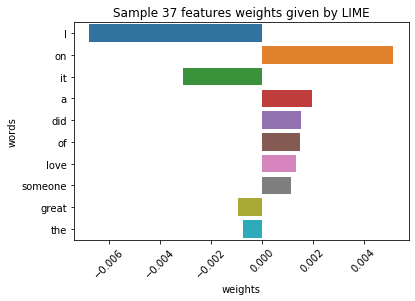

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="weights", y="words", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));

In [34]:
explanation.show_in_notebook()

In [38]:
# We choose a sample from test set
idx = 38
text_sample = texts_test[idx]
class_names = ['Not Spam', 'Spam']

print('Sample {}: last 80 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-80:]))
print('-'*50)
print('Probability(Spam) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

Sample 38: last 80 words (only part used by the model)
--------------------------------------------------
This is the 2nd time we have tried to contact u. U have won the £1450 prize to claim just call 09053750005 b4 310303. T&Cs/stop SMS 08718725756. 140ppm
--------------------------------------------------
1/1 [==============================] - 0s 25ms/step
Probability(Spam) = 0.9992022
True class: Spam
